In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [2]:
import numpy as np

import ujson
import attr
import random
import torch

from glob import glob
from tqdm import tqdm_notebook
from itertools import islice
from boltons.iterutils import pairwise, chunked_iter
from collections import Counter

from gensim.models import KeyedVectors

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import functional as F

In [3]:
vectors = KeyedVectors.load_word2vec_format(
    '../data/vectors/GoogleNews-vectors-negative300.bin.gz',
    binary=True,
)

In [210]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)
            
    def xy(self):
        for abstract in self.abstracts():
            yield from abstract.xy()

In [211]:
@attr.s
class Abstract:
    
    sentences = attr.ib()
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
            
    def xy(self):
        for i, sent in enumerate(self.sentences):
            x = sent.tensor()
            y = i / (len(self.sentences)-1)
            y = torch.FloatTensor([y])
            yield x, y

In [212]:
@attr.s
class Sentence:
    
    tokens = attr.ib()
    
    def tensor(self, dim=300, pad=50):
        x = [vectors[t] for t in self.tokens if t in vectors]
        x += [np.zeros(dim)] * pad
        x = x[:pad]
        x = list(reversed(x))
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [287]:
class Model(nn.Module):
    
    def __init__(self, embed_dim, rnn_dim, lin_dim):
        super().__init__()
        self.rnn_dim = rnn_dim
        self.rnn = nn.LSTM(embed_dim, rnn_dim, nonlinearity='relu', batch_first=True)
        self.lin1 = nn.Linear(rnn_dim, lin_dim)
        self.lin2 = nn.Linear(lin_dim, lin_dim)
        self.lin3 = nn.Linear(lin_dim, lin_dim)
        self.out = nn.Linear(lin_dim, 1)
        
    def init_hidden(self):
        return Variable(torch.zeros(1, 1, self.rnn_dim))
        
    def forward(self, x):
        hidden = self.init_hidden()
        rnn_out, y = self.rnn(x, hidden)
        y = F.relu(self.lin1(y))
        y = F.relu(self.lin2(y))
        y = F.relu(self.lin3(y))
        y = self.out(y)
        return y

In [288]:
train = Corpus('../data/train.json/*.json', 3000)

In [289]:
train_xy = list(train.xy())

HBox(children=(IntProgress(value=0, max=3000), HTML(value='')))

In [290]:
loader = DataLoader(train_xy, 100)

In [291]:
torch.manual_seed(1)

In [292]:
model = Model(300, 128, 128)

In [293]:
criterion = nn.MSELoss()

In [294]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [295]:
train_loss = []
for epoch in range(10):
    
    print(f'Epoch {epoch}')
    
    epoch_loss = 0
    for x, y in tqdm_notebook(loader):

        x = Variable(x)
        y = Variable(y)

        model.zero_grad()
        model.init_hidden()

        y_pred = model(x)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.data[0]
        
    epoch_loss /= len(loader)
    train_loss.append(epoch_loss)
    print(epoch_loss)

Epoch 0


HBox(children=(IntProgress(value=0, max=161), HTML(value='')))


0.11307716041062929
Epoch 1


HBox(children=(IntProgress(value=0, max=161), HTML(value='')))


0.09091591612892862
Epoch 2


HBox(children=(IntProgress(value=0, max=161), HTML(value='')))


0.08279335748705065
Epoch 3


HBox(children=(IntProgress(value=0, max=161), HTML(value='')))


0.07654068010471622
Epoch 4


HBox(children=(IntProgress(value=0, max=161), HTML(value='')))


0.07229234537352687
Epoch 5


HBox(children=(IntProgress(value=0, max=161), HTML(value='')))


0.06530188979661983
Epoch 6


HBox(children=(IntProgress(value=0, max=161), HTML(value='')))


0.06196748611071835
Epoch 7


HBox(children=(IntProgress(value=0, max=161), HTML(value='')))


0.05679649968417535
Epoch 8


HBox(children=(IntProgress(value=0, max=161), HTML(value='')))


0.05423728392823883
Epoch 9


HBox(children=(IntProgress(value=0, max=161), HTML(value='')))


0.051374091587451674


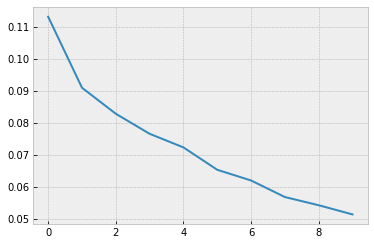

In [296]:
plt.plot(train_loss)

In [297]:
dev = Corpus('../data/dev.json/*.json', 1000)

In [298]:
correct = Counter()
total = Counter()

for ab in dev.abstracts():
    
    x, _ = zip(*ab.xy())

    x = Variable(torch.stack(x))
    y = model(x)
    
    y = np.array(y.data[0].tolist())[:,0]
    
    order = list(y.argsort().argsort())
    
    if sorted(order) == order:
        correct[len(order)] += 1
        
    total[len(order)] += 1

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [299]:
for slen in sorted(correct.keys()):
    print(slen, correct[slen] / total[slen])

2 0.8041237113402062
3 0.5165562913907285
4 0.287292817679558
5 0.04519774011299435
6 0.03418803418803419


In [300]:
sum(correct.values()) / sum(total.values())

0.22